In [ ]:
import pandas as pd
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import string
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense,Activation
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence, text
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras.models import load_model,Model
from tensorflow.keras.layers import Dense,SimpleRNN,Input,Dropout,Flatten,Concatenate,Bidirectional
from tensorflow.keras import regularizers,optimizers
import datetime
from collections import Counter

In [ ]:
#Reference:  https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py/47016862
def jaccard(str1,str2): 
    a=set(str1.lower().split()) 
    b=set(str2.lower().split())
    c=a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive//My Drive/Tweet Sentiment Extraction/updated_train.pkl','rb') as f:
     train=pickle.load(f)

with open('/content/drive//My Drive/Tweet Sentiment Extraction/preprocessed_test.pkl','rb') as f:
     test=pickle.load(f)

In [ ]:
train.head()

,textID,text,selected_text,sentiment,spelling,start_index,end_index
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,++++,0,6
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,++++,0,1
2,088c60f138,my boss is bullying me,bullying me,negative,++++,3,4
3,9642c003ef,what interview leave me alone,leave me alone,negative,++++,2,4
4,358bd9e861,sons of ABUSE why couldnt they put them on th...,sons of ABUSE,negative,++++,0,2


In [ ]:
test.head()

,textID,text,sentiment
0,f87dea47db,last session of the day,neutral
1,96d74cb729,shanghai is also really exciting precisely s...,positive
2,eee518ae67,recession hit veronique branquinho she has to ...,negative
3,01082688c6,happy bday,positive
4,33987a8ee5,i like it,positive


In [ ]:
text_split=train['text'].apply(lambda x: len(str(x).split())).tolist()

In [ ]:
max(text_split)

32

In [ ]:
#https://www.geeksforgeeks.org/numpy-zeros-python/
y=np.zeros((train.shape[0],max(text_split)+1))
for i in range(train.shape[0]):
  start=train['start_index'][i]
  end=train['end_index'][i]
  y[i][start:end+1]=1

In [ ]:
for i in [1,6,11,22]:
  print(train['start_index'][i],train['end_index'][i])
  print('\n')
  print(train['text'][i])
  print('\n')
  print(train['selected_text'][i])
  print('\n')
  print(y[i])
  print("="*150)

0 1


 sooo sad i will miss you here in san diego


sooo sad


[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 5


  feedings for the baby are fun when he is all smiles and coos


fun


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 3


i really really like the song love story by taylor swift


like


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 11


is cleaning the house for her family who is comming later today


is cleaning the house for her family who is comming later today


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
y.shape

(27381, 33)

In [ ]:
X=train[['textID','text','selected_text','sentiment']]

In [ ]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.15,random_state=42)

In [ ]:
print("X_train shape ",X_train.shape,"  X_test shape ",X_valid.shape)
print("\ny_train shape ",y_train.shape,"  y_test shape ",y_valid.shape)

X_train shape  (23273, 4)   X_test shape  (4108, 4)

y_train shape  (23273, 33)   y_test shape  (4108, 33)


In [ ]:
y_train=np.expand_dims(y_train,-1)
y_valid=np.expand_dims(y_valid,-1)
y_train.shape,y_valid.shape

((23273, 33, 1), (4108, 33, 1))

In [ ]:
train_text=X_train['text'].values
valid_text=X_valid['text'].values
train_sentiment=X_train['sentiment'].values
valid_sentiment=X_valid['sentiment'].values

In [ ]:
#Reference : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

tokenizer1=Tokenizer(lower=True,split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n',oov_token='<unw>')
tokenizer1.fit_on_texts(train_text)

max_len_text=32

train_text=tokenizer1.texts_to_sequences(train_text)
valid_text=tokenizer1.texts_to_sequences(valid_text)

train_text=sequence.pad_sequences(train_text,maxlen=max_len_text,padding='post')
valid_text=sequence.pad_sequences(valid_text,maxlen=max_len_text,padding='post')

word_index_text=tokenizer1.word_index
print(word_index_text)

{'<unw>': 1, 'i': 2, 'to': 3, 'the': 4, 'a': 5, 'my': 6, 'and': 7, 'you': 8, 'it': 9, 'is': 10, 'in': 11, 'for': 12, 'of': 13, 'im': 14, 'on': 15, 'me': 16, 'have': 17, 'that': 18, 'so': 19, 'but': 20, 'just': 21, 'with': 22, 'day': 23, 'be': 24, 'its': 25, 'at': 26, 'not': 27, 'was': 28, 'all': 29, 'good': 30, 'this': 31, 'now': 32, 'out': 33, 'up': 34, 'get': 35, 'are': 36, 'like': 37, 'no': 38, 'go': 39, 'dont': 40, 'do': 41, 'your': 42, 'going': 43, 'love': 44, 'too': 45, 'today': 46, 'work': 47, 'got': 48, 'abuse': 49, 'cant': 50, 'one': 51, 'from': 52, 'happy': 53, 'time': 54, 'what': 55, 'know': 56, 'lol': 57, 'u': 58, 'really': 59, 'back': 60, 'will': 61, 'about': 62, 'am': 63, 'had': 64, 'we': 65, 'there': 66, 'see': 67, 'can': 68, 'if': 69, 'some': 70, 'new': 71, 'well': 72, 'night': 73, 'home': 74, 'as': 75, 'want': 76, 'mothers': 77, 'when': 78, 'how': 79, 'more': 80, 'still': 81, 'much': 82, 'think': 83, 'thanks': 84, 'oh': 85, 'off': 86, 'they': 87, 'miss': 88, 'here': 89

In [ ]:
print(train_text.shape,valid_text.shape)

(23273, 32) (4108, 32)


In [ ]:
#Reference : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

tokenizer2=Tokenizer(lower=True,split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^_{|}~\t\n',oov_token='<unw>')
tokenizer2.fit_on_texts(train_sentiment)
max_len_sentiment=1

train_sentiment=tokenizer2.texts_to_sequences(train_sentiment)
valid_sentiment=tokenizer2.texts_to_sequences(valid_sentiment)

train_sentiment=sequence.pad_sequences(train_sentiment,maxlen=max_len_sentiment,padding='post')
valid_sentiment=sequence.pad_sequences(valid_sentiment,maxlen=max_len_sentiment,padding='post')

word_index_sentiment=tokenizer2.word_index
print(word_index_sentiment)

{'<unw>': 1, 'neutral': 2, 'positive': 3, 'negative': 4}


In [ ]:
print(train_sentiment.shape,valid_sentiment.shape)

(23273, 1) (4108, 1)


In [ ]:
# load the GloVe vectors in a dictionary:
embeddings_index={}
with open('/content/drive//My Drive/Tweet Sentiment Extraction/glove.840B.300d.txt') as f:
  for line in tqdm(f):
    values=line.split(' ')
    word=values[0]
    coefs=np.asarray([float(val) for val in values[1:]])
    embeddings_index[word]=coefs
print('Found %s word vectors.' % len(embeddings_index))

2196018it [04:45, 7680.30it/s]

Found 2196017 word vectors.


In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix_text=np.zeros((len(word_index_text) + 1, 300))
for word, i in tqdm(word_index_text.items()):
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_text[i]=embedding_vector

100%|██████████| 23999/23999 [00:00<00:00, 387111.68it/s]


In [ ]:
embedding_matrix_text.shape

(24000, 300)

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix_sentiment=np.zeros((len(word_index_sentiment) + 1, 300))
for word, i in tqdm(word_index_sentiment.items()):
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_sentiment[i]=embedding_vector

100%|██████████| 4/4 [00:00<00:00, 25458.60it/s]


In [ ]:
embedding_matrix_sentiment.shape

(5, 300)

#Bidirectional-LSTM

In [ ]:
text_input=Input(shape=(max_len_text,),name='text_input')
embd_text=Embedding(len(word_index_text)+1, #embedding layer with glove vectors as embeddings
                    300,
                    weights=[embedding_matrix_text],
                    input_length=max_len_text,
                    trainable=False,mask_zero=True,name='embedding_text')(text_input) #masking the input values with mask_zero= True


sentiment_input=Input(shape=(max_len_sentiment,),name='sentiment_input')
embd_sentiment=Embedding(len(word_index_sentiment)+1, #embedding layer with glove vectors as embeddings
                    300,
                    weights=[embedding_matrix_sentiment],
                    input_length=max_len_text,
                    trainable=False,mask_zero=True,name='embedding_sentiment')(sentiment_input) #masking the input values with mask_zero= True


con=Concatenate(axis=1)([embd_text,embd_sentiment])

lstm=Bidirectional(LSTM(16,return_sequences=True,dropout=0.4,name='lstm'))(con)

#dense layers with drop outs and batch normalisation
m=Dense(8,activation="relu",kernel_regularizer=regularizers.l2(0.0001))(lstm) 
m=Dropout(0.5)(m)
m=Dense(4,activation="relu",kernel_regularizer=regularizers.l2(0.0001))(m)
output=Dense(1,activation='sigmoid',name='output')(m)

model=Model(inputs=[text_input,sentiment_input],outputs=[output])

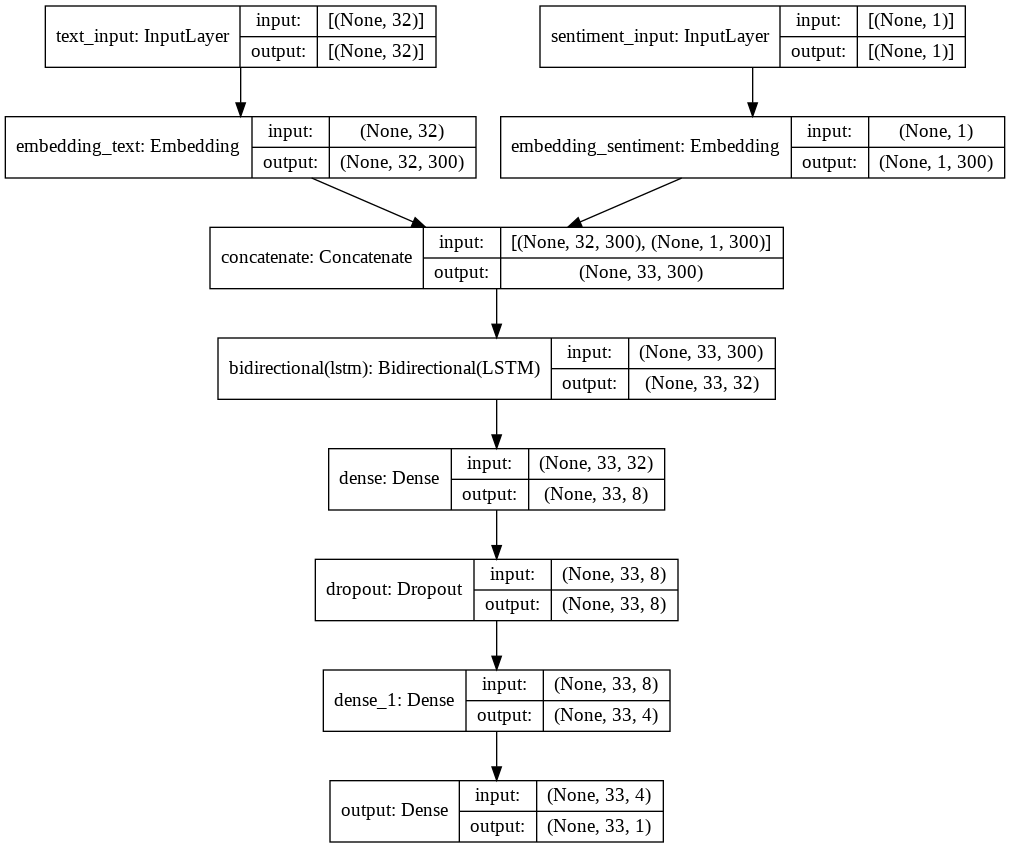

In [ ]:
tf.keras.utils.plot_model(model,'Model.png',show_shapes=True,show_layer_names=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 32)]         0                                            
__________________________________________________________________________________________________
sentiment_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_text (Embedding)      (None, 32, 300)      7200000     text_input[0][0]                 
__________________________________________________________________________________________________
embedding_sentiment (Embedding) (None, 1, 300)       1500        sentiment_input[0][0]            
______________________________________________________________________________________________

In [ ]:
log_dir=os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True,write_grads=True)

checkpoint_filepath='/content/drive//My Drive/Tweet Sentiment Extraction/Bi-LSTM.h5'
model_checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_loss',save_best_only=True,verbose=1)


#https://keras.io/api/metrics/ 

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])
callback=[model_checkpoint_callback,tensorboard]

#https://datascience.stackexchange.com/questions/34444/what-is-the-difference-between-fit-and-fit-generator-in-keras
history=model.fit([train_text,train_sentiment],y_train,epochs=20,batch_size=128,validation_data=([valid_text,valid_sentiment],[y_valid]),verbose=1,
                                                                                                                                    callbacks=callback)


Epoch 1/20
182/182 [==============================] - 53s 246ms/step - loss: 0.2194 - accuracy: 0.7231 - val_loss: 0.1666 - val_accuracy: 0.8123

Epoch 00001: val_loss improved from inf to 0.16664, saving model to /content/drive//My Drive/Tweet Sentiment Extraction/Bi-GRU.h5
Epoch 2/20
182/182 [==============================] - 44s 241ms/step - loss: 0.1848 - accuracy: 0.7863 - val_loss: 0.1607 - val_accuracy: 0.8286

Epoch 00002: val_loss improved from 0.16664 to 0.16069, saving model to /content/drive//My Drive/Tweet Sentiment Extraction/Bi-GRU.h5
Epoch 3/20
182/182 [==============================] - 44s 241ms/step - loss: 0.1771 - accuracy: 0.8129 - val_loss: 0.1589 - val_accuracy: 0.8322

Epoch 00003: val_loss improved from 0.16069 to 0.15888, saving model to /content/drive//My Drive/Tweet Sentiment Extraction/Bi-GRU.h5
Epoch 4/20
182/182 [==============================] - 43s 238ms/step - loss: 0.1714 - accuracy: 0.8240 - val_loss: 0.1578 - val_accuracy: 0.8330

Epoch 00004: val_l

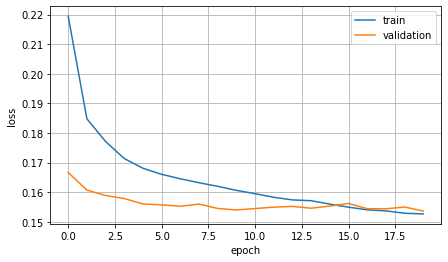

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.grid()
plt.show()

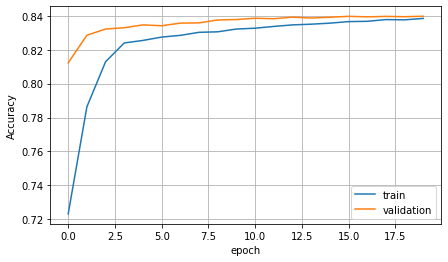

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'])
plt.grid()
plt.show()

#Training Dataset

In [ ]:
train_pred=model.predict([train_text,train_sentiment])
#https://www.geeksforgeeks.org/numpy-squeeze-in-python/
train_pred=np.squeeze(train_pred)
train_pred=np.round(train_pred)
train_pred.shape

(23273, 33)

In [ ]:
pred=[]
for vector in train_pred:
  index=[]
  for i,value in enumerate(vector):
    if value == 1:
      index.append(i)
  pred.append(np.array(index))
print(len(pred))

23273


In [ ]:
X_train['prediction']=pred
X_train.head(20)

,textID,text,selected_text,sentiment,prediction
8542,97b3fee0c0,work til,work til,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
26493,cadd44e0ed,ok sending me messages asking to set my blog l...,ok sending me messages asking to set my blog l...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
14835,d27e0ab61d,welcoming new followers thanks for the...,thanks for the love,positive,"[3, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ..."
9140,3f1dc607f2,im such a nerd reading my first of many books ...,nerd,negative,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2..."
22561,fe4e8393d5,is going to see the hannah montana movielolwha...,is going to see the hannah montana movielolwha...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
26245,e0a172bc68,i cut my hand open,i cut my hand open,negative,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
2870,0068b3323c,lavish i told diamond to follow you and why u ...,i told diamond to follow you and why u aitn sh...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
19153,62fbde9857,you tell us,you tell us,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
27222,f1142bc75a,ss back to the gym project finally finished A...,filthy,negative,"[9, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27..."
20311,6abf30463f,nah i understand you cant cancel i just wante...,nah i understand you cant cancel i just wanted...,positive,"[2, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20, ..."


In [ ]:
def get_text(x):
  pred=[]
  text=x[0]
  index=x[1]
  text=text.split()
  l=len(text)
  for i in index:
    if i < l:
      pred.append(text[i])
  return pred

In [ ]:
pred_text=X_train[['text','prediction']].apply(lambda x: get_text(x),axis=1)
X_train['pred_text']=pred_text
X_train['pred_text']=X_train['pred_text'].apply(lambda x: ' '.join(x))
X_train.head(20)

,textID,text,selected_text,sentiment,prediction,pred_text
8542,97b3fee0c0,work til,work til,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",work til
26493,cadd44e0ed,ok sending me messages asking to set my blog l...,ok sending me messages asking to set my blog l...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",ok sending me messages asking to set my blog l...
14835,d27e0ab61d,welcoming new followers thanks for the...,thanks for the love,positive,"[3, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",thanks love
9140,3f1dc607f2,im such a nerd reading my first of many books ...,nerd,negative,"[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 2...",
22561,fe4e8393d5,is going to see the hannah montana movielolwha...,is going to see the hannah montana movielolwha...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",is going to see the hannah montana movielolwha...
26245,e0a172bc68,i cut my hand open,i cut my hand open,negative,"[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",cut my hand
2870,0068b3323c,lavish i told diamond to follow you and why u ...,i told diamond to follow you and why u aitn sh...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",lavish i told diamond to follow you and why u ...
19153,62fbde9857,you tell us,you tell us,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",you tell us
27222,f1142bc75a,ss back to the gym project finally finished A...,filthy,negative,"[9, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27...",filthy
20311,6abf30463f,nah i understand you cant cancel i just wante...,nah i understand you cant cancel i just wanted...,positive,"[2, 4, 5, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...",understand cant cancel


In [ ]:
X_train['jaccard']=X_train.apply(lambda x: jaccard(x.selected_text,x.pred_text),axis=1)
print('Mean training Jaccard score:',np.mean(X_train['jaccard']))
print("="*150)
print('nMean jaccard score for positive sentiment tweets:',np.mean(X_train[X_train['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(X_train[X_train['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(X_train[X_train['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.6663297918238207
nMean jaccard score for positive sentiment tweets: 0.45831815165295114
Mean jaccard score for negative sentiment tweets 0.4339671834559042
Mean jaccard score for neutral sentiment tweets 0.9872496749240344


#Validation Dataset

In [ ]:
valid_pred=model.predict([valid_text,valid_sentiment])
valid_pred=np.squeeze(valid_pred)
valid_pred=np.round(valid_pred)
valid_pred.shape

(4108, 33)

In [ ]:
pred=[]
for vector in valid_pred:
  index=[]
  for i,value in enumerate(vector):
    if value == 1:
      index.append(i)
  pred.append(np.array(index))
print(len(pred))

4108


In [ ]:
X_valid['prediction']=pred
X_valid.head(20)

,textID,text,selected_text,sentiment,prediction
27149,a3125b3dc1,hes back oh noes have you missed me work has ...,insane,negative,"[27, 28, 29, 30, 31]"
15026,90944c6528,god opened the clouds and said i hate you josh,i hate you josh,negative,"[0, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 1..."
14192,2d003b7d57,everyone says that,everyone says that,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
20828,0d663acecc,i wonder if i should put a bet on cubs winning...,love,positive,"[19, 27, 28, 29, 30, 31]"
5135,3a4ff44f1a,i will do that,i will do that,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3053,0252b13fbe,do u ever answer ur fans on here i wish u wou...,do u ever answer ur fans on here i wish u woul...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
15488,72edbb4f6d,now ive got new frensfrm germanymexico n fra...,now ive got new frensfrm germanymexico n fra...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
20778,9b7a9dfd99,already finished chatting haha,already finished chatting haha,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
24362,30cc3c9612,i gave up following she seems really nice b...,i gave up following she seems really nice bu...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
17418,fd200545ec,my inner desire is to go to an isle in the mid...,my inner desire is to go to an isle in the mid...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
pred_text=X_valid[['text','prediction']].apply(lambda x:get_text(x),axis=1)
X_valid['pred_text']=pred_text
X_valid['pred_text']=X_valid['pred_text'].apply(lambda x: ' '.join(x))
X_valid.head(20)

,textID,text,selected_text,sentiment,prediction,pred_text
27149,a3125b3dc1,hes back oh noes have you missed me work has ...,insane,negative,"[27, 28, 29, 30, 31]",
15026,90944c6528,god opened the clouds and said i hate you josh,i hate you josh,negative,"[0, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 1...",god i hate you
14192,2d003b7d57,everyone says that,everyone says that,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",everyone says that
20828,0d663acecc,i wonder if i should put a bet on cubs winning...,love,positive,"[19, 27, 28, 29, 30, 31]",love
5135,3a4ff44f1a,i will do that,i will do that,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",i will do that
3053,0252b13fbe,do u ever answer ur fans on here i wish u wou...,do u ever answer ur fans on here i wish u woul...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",do u ever answer ur fans on here i wish u woul...
15488,72edbb4f6d,now ive got new frensfrm germanymexico n fra...,now ive got new frensfrm germanymexico n fra...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",now ive got new frensfrm germanymexico n franc...
20778,9b7a9dfd99,already finished chatting haha,already finished chatting haha,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",already finished chatting haha
24362,30cc3c9612,i gave up following she seems really nice b...,i gave up following she seems really nice bu...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",i gave up following she seems really nice but ...
17418,fd200545ec,my inner desire is to go to an isle in the mid...,my inner desire is to go to an isle in the mid...,neutral,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",my inner desire is to go to an isle in the mid...


In [ ]:
X_valid['jaccard']=X_valid.apply(lambda x: jaccard(x.selected_text,x.pred_text),axis=1)
print('Mean training Jaccard score:',np.mean(X_valid['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(X_valid[X_valid['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(X_valid[X_valid['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(X_valid[X_valid['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.6389215473432809
Mean jaccard score for positive sentiment tweets: 0.4263000262826317
Mean jaccard score for negative sentiment tweets 0.37599119930438635
Mean jaccard score for neutral sentiment tweets 0.9874526469898516


#Submission

In [ ]:
model=load_model('/content/drive//My Drive/Tweet Sentiment Extraction/Bi-GRU.h5')

In [ ]:
test_text=test['text'].values
test_sentiment=test['sentiment'].values

In [ ]:
test_text=tokenizer1.texts_to_sequences(test_text)
test_text=sequence.pad_sequences(test_text,maxlen=max_len_text,padding='post')

In [ ]:
test_sentiment=tokenizer2.texts_to_sequences(test_sentiment)
test_sentiment=sequence.pad_sequences(test_sentiment,maxlen=max_len_sentiment,padding='post')

In [ ]:
test_pred=model.predict([test_text,test_sentiment])
test_pred=np.squeeze(test_pred)
test_pred=np.round(test_pred)
test_pred.shape

(3534, 33)

In [ ]:
pred=[]
for vector in test_pred:
  index=[]
  for i,value in enumerate(vector):
    if value == 1:
      index.append(i)
  pred.append(np.array(index))
print(len(pred))

3534


In [ ]:
def get_text(x):
  pred=[]
  text=x[0]
  index=x[1]
  text=text.split()
  l=len(text)
  for i in index:
    if i < l:
      pred.append(text[i])
  return pred

In [ ]:
test['prediction']=pred
pred_text=test[['text','prediction']].apply(lambda x:get_text(x),axis=1)
test['selected_text']=pred_text
test['selected_text']=test['selected_text'].apply(lambda x: ' '.join(x))

In [ ]:
test.drop(['text','sentiment','prediction'],axis=1,inplace=True)

In [ ]:
test.tail()

,textID,selected_text
3529,e5f0e6ef4b,very tired
3530,416863ce47,thanks for the
3531,6332da480c,sinking into depression
3532,df1baec676,i love your videos
3533,469e15c5a8,cute


In [ ]:
test.to_csv("/content/drive//My Drive/Tweet Sentiment Extraction/Bi-GRU_submission.csv",index=False)